# 19.2 Sensitivity by Band

**Chapter**: 19 - Evaluating Causal Models  
**Section**: 2 - Sensitivity by Band  
**Facure Source**: 19-Evaluating-Causal-Models.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-16

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [The Band Strategy](#11-the-band-strategy)
   - 1.2 [Estimating Sensitivity](#12-estimating-sensitivity)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [The Sensitivity Estimator](#21-the-sensitivity-estimator)
   - 2.2 [What Makes a Good Model](#22-what-makes-a-good-model)
3. [Implementation](#3-implementation)
4. [Numeric Demonstration](#4-numeric-demonstration)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, stats,
    load_facure_data,
    set_notebook_style,
    create_tufte_figure,
    apply_tufte_style,
    TUFTE_PALETTE,
    COLORS,
)

import statsmodels.formula.api as smf
from sklearn.ensemble import GradientBoostingRegressor
from toolz import curry
import warnings
warnings.filterwarnings('ignore')

set_notebook_style()
np.random.seed(123)

print("Imports loaded successfully")

Imports loaded successfully


---

## 1. Facure's Intuition

> **Interview Relevance**: The band strategy is a simple but powerful evaluation technique. Being able to explain and implement it is valuable for applied causal roles.

### 1.1 The Band Strategy

The idea is simple:

1. **Rank units** by predicted CATE (or any score)
2. **Split into bands** (quantiles)
3. **Estimate actual treatment effect** in each band
4. **Compare**: Do bands have different effects?

```
Band Strategy ───────────────────────────────────────────

  Units sorted by predicted τ̂(x):
  ─────────────────────────────────────────────────────
  |  Band 1   |  Band 2   |  Band 3   |  Band 4   |   
  |  (High)   |           |           |  (Low)    |
  ─────────────────────────────────────────────────────
  
  Then estimate actual τ in each band:
  τ̂_band = Ȳ(T=1) - Ȳ(T=0) within band
  
  Good model → τ̂_band1 > τ̂_band2 > τ̂_band3 > τ̂_band4
─────────────────────────────────────────────────────────
```

### 1.2 Estimating Sensitivity

For **continuous treatment** (like price), we use the regression coefficient:

$$\hat{\beta}_1 = \frac{\sum(T_i - \bar{T})(Y_i - \bar{Y})}{\sum(T_i - \bar{T})^2}$$

This is the slope from regressing Y on T — the average sensitivity within the band.

In [2]:
# Load and prepare data
prices = load_facure_data('ice_cream_sales.csv')  # Non-random (training)
prices_rnd = load_facure_data('ice_cream_sales_rnd.csv')  # Random (evaluation)

# Build models (same as notebook 01)
X = ["temp", "weekday", "cost", "price"]
y = "sales"

# CATE model
m1 = smf.ols("sales ~ price*cost + price*C(weekday) + price*temp", data=prices).fit()

# Predictive model
m2 = GradientBoostingRegressor(max_depth=5, n_estimators=100, random_state=42)
m2.fit(prices[X], prices[y])

# Generate predictions
def predict_sensitivity(model, df, h=0.01):
    df_plus = df.copy()
    df_plus['price'] = df['price'] + h
    return (model.predict(df_plus) - model.predict(df)) / h

prices_rnd_pred = prices_rnd.copy()
prices_rnd_pred['sensitivity_m_pred'] = predict_sensitivity(m1, prices_rnd)
prices_rnd_pred['pred_m_pred'] = m2.predict(prices_rnd[X])
prices_rnd_pred['rand_m_pred'] = np.random.uniform(size=len(prices_rnd))

print("Data and models ready for evaluation.")

Data and models ready for evaluation.


---

## 2. Formal Treatment

### 2.1 The Sensitivity Estimator

For continuous treatment, **sensitivity** is the slope of Y on T:

$$\hat{\tau} = \hat{\beta}_1 = \frac{\text{Cov}(T, Y)}{\text{Var}(T)} = \frac{\sum(T_i - \bar{T})(Y_i - \bar{Y})}{\sum(T_i - \bar{T})^2}$$

**Interpretation**: Average change in Y per unit change in T.

**Key assumption**: Treatment is randomized (or exogenous) within the band.
- If so: This is the causal effect
- If not: This is just a correlation

### 2.2 What Makes a Good Model

A model is **useful** for personalization if:

1. **Bands have different sensitivities**: $\hat{\tau}_{band1} \neq \hat{\tau}_{band2}$
2. **Ordering is correct**: High-predicted → High-actual

A **random model** would give bands with roughly the **same** sensitivity (all ≈ ATE).

---

## 3. Implementation

In [3]:
@curry
def sensitivity(data, y, t):
    """
    Estimate sensitivity (slope) using simple linear regression.
    
    Parameters
    ----------
    data : DataFrame
    y : str, outcome column name
    t : str, treatment column name
    
    Returns
    -------
    float : estimated sensitivity (beta_1)
    """
    t_bar = data[t].mean()
    y_bar = data[y].mean()
    cov = np.sum((data[t] - t_bar) * (data[y] - y_bar))
    var = np.sum((data[t] - t_bar) ** 2)
    return cov / var if var > 0 else 0

# Test on full data
overall_sens = sensitivity(prices_rnd_pred, 'sales', 'price')
print(f"Overall sensitivity (ATE): {overall_sens:.3f}")
print(f"\nInterpretation: On average, each $1 price increase")
print(f"               decreases sales by {abs(overall_sens):.1f} units")

Overall sensitivity (ATE): -2.552

Interpretation: On average, each $1 price increase
               decreases sales by 2.6 units


In [4]:
def sensitivity_by_band(df, pred, y, t, bands=10):
    """
    Compute sensitivity within quantile bands.
    
    Parameters
    ----------
    df : DataFrame
    pred : str, column with predictions to create bands from
    y : str, outcome column
    t : str, treatment column
    bands : int, number of quantile bands
    
    Returns
    -------
    Series : sensitivity estimate for each band
    """
    return (df
            .assign(**{f"{pred}_band": pd.qcut(df[pred], q=bands, duplicates='drop')})
            .groupby(f"{pred}_band", observed=True)
            .apply(sensitivity(y=y, t=t), include_groups=False))

# Test
sens_m1 = sensitivity_by_band(prices_rnd_pred, 'sensitivity_m_pred', 'sales', 'price', bands=5)
print("Sensitivity by band (CATE model):")
print(sens_m1.round(3))

Sensitivity by band (CATE model):
sensitivity_m_pred_band
(-18.778000000000002, -12.538]   -10.8530
(-12.538, -1.941]                 -2.6690
(-1.941, -0.421]                   0.9170
(-0.421, 0.898]                    0.0630
(0.898, 5.565]                    -1.2300
dtype: float64


---

## 4. Numeric Demonstration

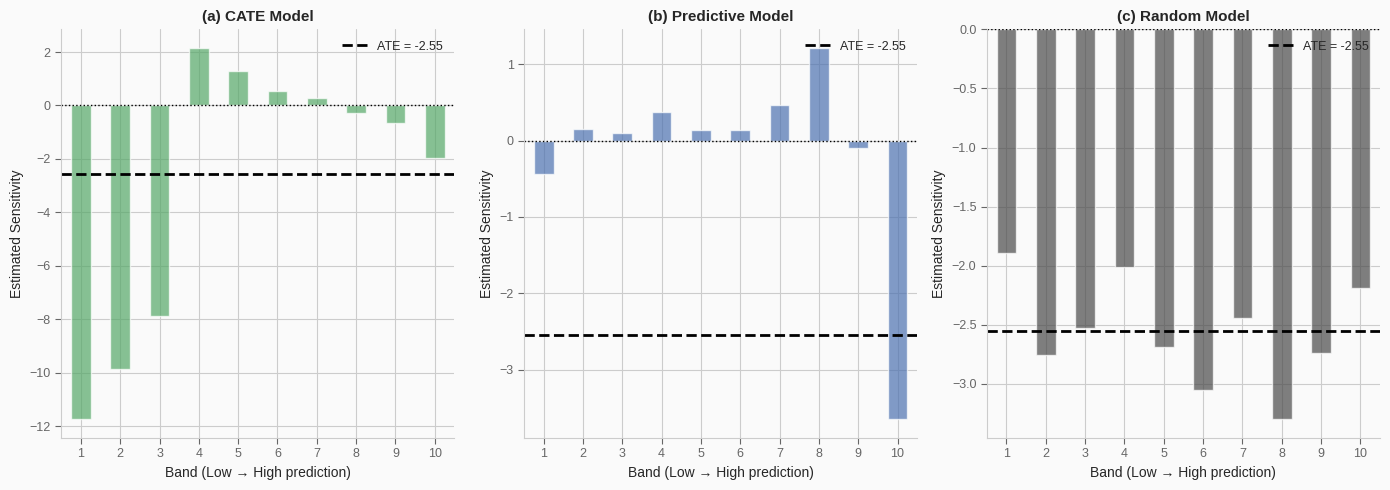

In [5]:
# Compute sensitivity by band for all three models
models = ['sensitivity_m_pred', 'pred_m_pred', 'rand_m_pred']
model_names = ['CATE Model', 'Predictive Model', 'Random Model']
n_bands = 10

# Create figure
fig, axes = create_tufte_figure(1, 3, figsize=(14, 5))

colors = [COLORS['green'], COLORS['blue'], TUFTE_PALETTE['primary']]

for i, (model, name, color) in enumerate(zip(models, model_names, colors)):
    ax = axes[i]
    
    # Compute sensitivity by band
    sens_by_band = sensitivity_by_band(prices_rnd_pred, model, 'sales', 'price', bands=n_bands)
    
    # Plot
    sens_by_band.plot(kind='bar', ax=ax, color=color, alpha=0.7, edgecolor='white')
    ax.axhline(overall_sens, color='black', linestyle='--', linewidth=2, 
               label=f'ATE = {overall_sens:.2f}')
    ax.axhline(0, color='black', linestyle=':', linewidth=1)
    
    ax.set_xlabel('Band (Low → High prediction)')
    ax.set_ylabel('Estimated Sensitivity')
    ax.set_title(f'({chr(97+i)}) {name}', fontweight='bold')
    ax.legend(loc='upper right', frameon=False, fontsize=9)
    ax.set_xticklabels(range(1, n_bands+1), rotation=0)

plt.tight_layout()
plt.show()

In [6]:
# Interpretation
print("=" * 60)
print("INTERPRETATION")
print("=" * 60)
print("""
(a) CATE Model:
    - Bands have DIFFERENT sensitivities
    - Left bands (low prediction) have very negative sensitivity
    - Right bands (high prediction) have near-zero sensitivity
    -> Model successfully identifies price-sensitive vs insensitive days!

(b) Predictive Model:
    - Bands have roughly SIMILAR sensitivities
    - All bands close to the ATE line
    -> Model separates by sales LEVEL, not price SENSITIVITY

(c) Random Model:
    - Bands have roughly the SAME sensitivity
    - All bands ≈ ATE (expected)
    -> Random segmentation is useless (baseline)
""")

INTERPRETATION

(a) CATE Model:
    - Bands have DIFFERENT sensitivities
    - Left bands (low prediction) have very negative sensitivity
    - Right bands (high prediction) have near-zero sensitivity
    -> Model successfully identifies price-sensitive vs insensitive days!

(b) Predictive Model:
    - Bands have roughly SIMILAR sensitivities
    - All bands close to the ATE line
    -> Model separates by sales LEVEL, not price SENSITIVITY

(c) Random Model:
    - Bands have roughly the SAME sensitivity
    - All bands ≈ ATE (expected)
    -> Random segmentation is useless (baseline)



In [7]:
# Quantify the difference
print("=" * 60)
print("QUANTITATIVE COMPARISON")
print("=" * 60)

for model, name in zip(models, model_names):
    sens_by_band = sensitivity_by_band(prices_rnd_pred, model, 'sales', 'price', bands=5)
    sens_range = sens_by_band.max() - sens_by_band.min()
    sens_std = sens_by_band.std()
    
    print(f"\n{name}:")
    print(f"  Band sensitivities: {sens_by_band.values.round(2)}")
    print(f"  Range (max - min): {sens_range:.2f}")
    print(f"  Std dev: {sens_std:.2f}")

print("\n" + "="*60)
print("Larger range/std = more differentiation = better model!")

QUANTITATIVE COMPARISON

CATE Model:
  Band sensitivities: [-10.85  -2.67   0.92   0.06  -1.23]
  Range (max - min): 11.77
  Std dev: 4.73

Predictive Model:
  Band sensitivities: [-0.24  0.2   0.15  0.98 -3.87]
  Range (max - min): 4.85
  Std dev: 1.91

Random Model:
  Band sensitivities: [-2.32 -2.27 -2.88 -2.86 -2.45]
  Range (max - min): 0.62
  Std dev: 0.30

Larger range/std = more differentiation = better model!


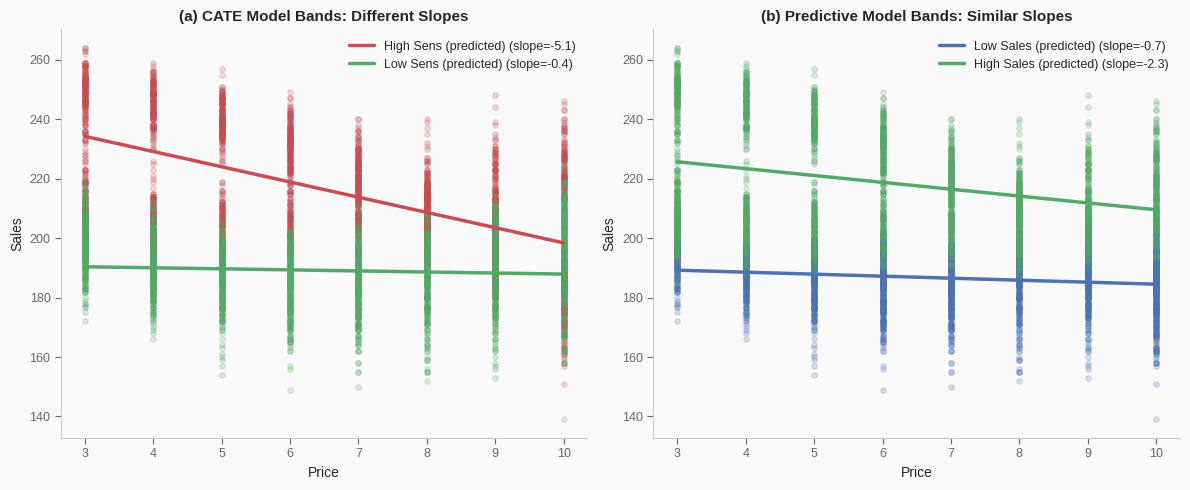


Key observation: CATE model creates bands with different slopes!


In [8]:
# Visual: FacetGrid-style comparison
import seaborn as sns

fig, axes = create_tufte_figure(1, 2, figsize=(12, 5))

# Create 2 bands for each model for cleaner visualization
prices_rnd_pred['sens_band'] = pd.qcut(prices_rnd_pred['sensitivity_m_pred'], q=2, 
                                        labels=['High Sens (predicted)', 'Low Sens (predicted)'])

# Panel 1: CATE model bands
ax = axes[0]
for band, color in [('High Sens (predicted)', COLORS['red']), 
                    ('Low Sens (predicted)', COLORS['green'])]:
    subset = prices_rnd_pred[prices_rnd_pred['sens_band'] == band]
    
    # Scatter
    ax.scatter(subset['price'], subset['sales'], alpha=0.2, s=15, c=color)
    
    # Regression line
    z = np.polyfit(subset['price'], subset['sales'], 1)
    x_range = np.linspace(subset['price'].min(), subset['price'].max(), 100)
    ax.plot(x_range, np.poly1d(z)(x_range), c=color, lw=2.5, 
            label=f'{band} (slope={z[0]:.1f})')

ax.set_xlabel('Price')
ax.set_ylabel('Sales')
ax.set_title('(a) CATE Model Bands: Different Slopes', fontweight='bold')
ax.legend(frameon=False, loc='upper right', fontsize=9)

# Panel 2: Predictive model bands
prices_rnd_pred['pred_band'] = pd.qcut(prices_rnd_pred['pred_m_pred'], q=2, 
                                        labels=['Low Sales (predicted)', 'High Sales (predicted)'])
ax = axes[1]
for band, color in [('Low Sales (predicted)', COLORS['blue']), 
                    ('High Sales (predicted)', COLORS['green'])]:
    subset = prices_rnd_pred[prices_rnd_pred['pred_band'] == band]
    
    ax.scatter(subset['price'], subset['sales'], alpha=0.2, s=15, c=color)
    z = np.polyfit(subset['price'], subset['sales'], 1)
    x_range = np.linspace(subset['price'].min(), subset['price'].max(), 100)
    ax.plot(x_range, np.poly1d(z)(x_range), c=color, lw=2.5, 
            label=f'{band} (slope={z[0]:.1f})')

ax.set_xlabel('Price')
ax.set_ylabel('Sales')
ax.set_title('(b) Predictive Model Bands: Similar Slopes', fontweight='bold')
ax.legend(frameon=False, loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

print("\nKey observation: CATE model creates bands with different slopes!")

```
Key Takeaways ───────────────────────────────────────────

1. Sensitivity by band is a visual evaluation tool
   - Create quantile bands from predictions
   - Estimate actual sensitivity in each band
   - Bar plot shows differentiation

2. Good CATE model
   - Bands have DIFFERENT sensitivities
   - High-prediction bands have higher actual effect
   - Large range/std across bands

3. Random model baseline
   - All bands ≈ ATE
   - No differentiation
   - Any model must beat this!
   
4. Limitation
   - Can't summarize to single number
   - Need cumulative gain for that (next notebook)
─────────────────────────────────────────────────────────
```

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Meta E5, DS)**: *"Explain the sensitivity-by-band evaluation method for CATE models."*

<details>
<summary>Solution</summary>

**The method**:

1. **Sort** units by predicted CATE (or score)
2. **Split** into K quantile bands (e.g., deciles)
3. **Estimate** actual treatment effect in each band:
   - For continuous T: slope coefficient $\hat{\beta}_1 = \text{Cov}(T,Y)/\text{Var}(T)$
   - For binary T: difference in means $\bar{Y}_{T=1} - \bar{Y}_{T=0}$
4. **Visualize** as bar plot

**Interpretation**:
- Good model: Bands have different treatment effects
- Random model: All bands ≈ ATE
- Better differentiation = better model

**Requirements**:
- Need randomized data (or valid causal identification)
- Simple linear regression is sufficient

**Limitations**:
- No single metric (hard to compare models precisely)
- Cumulative gain curve is more quantitative

</details>

---

**Q2 (Amazon L6, Econ)**: *"How do you estimate treatment effect for continuous treatments?"*

<details>
<summary>Solution</summary>

**The estimator: Regression slope**

For continuous treatment T and outcome Y:

$$\hat{\tau} = \hat{\beta}_1 = \frac{\text{Cov}(T, Y)}{\text{Var}(T)} = \frac{\sum(T_i - \bar{T})(Y_i - \bar{Y})}{\sum(T_i - \bar{T})^2}$$

**Interpretation**: Average change in Y per unit change in T.

**Why this works**:
- If T is randomized: $E[\hat{\beta}_1] = E[\partial Y/\partial T]$
- This is the causal derivative (marginal effect)

**For binary treatment comparison**:
- Binary: $\hat{\tau} = \bar{Y}_{T=1} - \bar{Y}_{T=0}$
- Continuous: $\hat{\tau} = \text{Cov}(T,Y)/\text{Var}(T)$
- Same principle: comparing outcomes across treatment levels

**Assumption**: Treatment is exogenous (randomized or conditionally randomized).

</details>

---

**Q3 (Google L5, Quant)**: *"What distinguishes a good CATE model from a random model in the sensitivity-by-band analysis?"*

<details>
<summary>Solution</summary>

**Random model baseline**:
- Random predictions → Random bands
- Each band is a random sample of the data
- All bands have treatment effect ≈ overall ATE
- No differentiation: flat bar chart

**Good CATE model**:
- Predictions correlate with actual treatment effect
- High-prediction band contains high-effect units
- Low-prediction band contains low-effect units
- Differentiation: descending bar chart

**Quantitative metrics**:
1. **Range**: $\max(\hat{\tau}_{bands}) - \min(\hat{\tau}_{bands})$
   - Random: Close to 0
   - Good model: Large positive value

2. **Standard deviation** across bands:
   - Random: Low
   - Good model: High

3. **Ordering**: Spearman correlation between band rank and actual sensitivity
   - Random: ≈ 0
   - Good model: Close to 1

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 19: "Evaluating Causal Models."

[^2]: Gutierrez, P. and Gérardy, J. Y. (2017). Causal Inference and Uplift Modeling: A Review of the Literature. *JMLR Workshop and Conference Proceedings*, 67, 1-13.

[^3]: Radcliffe, N. J. (2007). Using Control Groups to Target on Predicted Lift. *Direct Market Journal*, 3, 14-21.

---

**Next**: [03. Cumulative Gain Curves](./03_cumulative_gain.ipynb) — Quantitative evaluation with a single metric